# PerplexityLab for Machine Learning

Let's see how PerplexityLab can help us to quickly develop and analyse a typical Machine Learning pipeline.

The objective will be to study how the number of training examples, layers and neurons of a multilayer perceptron impact in its approximation power. We will test this pipeline on the MNIST dataset just to make thigs more familiar.

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%load_ext autoreload

In [3]:
import os

import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn import datasets

from src.DataManager import DataManager, JOBLIB
from src.LabPipeline import LabPipeline
from src.viz_utils import generic_plot

### Define experiment

First we will load the dataset and write down the definition of what is for us our experiment. The input variables to the function will be the parameters of our project and later we will choose what to try in order to see the behaviour.

In [24]:
def create_dataset(dataset_name: str):
    # the input variable "dataset_name" is a tring that will be used to retreive the actual dataset.
    data = getattr(datasets, f"load_{dataset_name}")()
    
    # the relevant variables of our experiment that we wish to save
    return {
        "X": data.data,
        "y": data.target
    }

def run_nn_loop(X, y, p_train, p_test, num_neurons, num_layers, activation, seed):
    """
    From the input variables, all are new except from X and y which are the result of the preprocessing function.
    The LabPipeline instance at the moment of running the experiments will automatically search for this variables 
    and give them as input to this function. For this, the "preprocessing" function should be set to run before.
    """
    # Let's define our Perceptron
    nn = MLPClassifier(
        hidden_layer_sizes=[num_neurons]*num_layers, # here the parameters play their role 
        activation=activation, # maybe the activation function is relevant
        random_state=seed, # to ensure reproducibility,
        max_iter=10000,
        learning_rate_init=0.1        
    )
    assert p_train + p_test <= 1, "Number of train and test examples should not exceed length of dataset."
    n_train = int(len(y)*p_train)
    n_test = int(len(y)*p_test)
    nn.fit(X[:n_train], y[:n_train]) # number of train examples to be used
    predictions = nn.predict(X[-n_test:]) # predictions
    
    # the relevant variables of our experiment that we wish to save
    return {
        "predictions": predictions,
        "coefs": nn.coefs_,
        "intercepts_": nn.intercepts_
    }

def calculate_errors(y, predictions):
    """
    Note that for this experiment, the variables are only outputs of previous layers so no new prject 
    parameter is needed
    """
    return {
        "missclassification_error": y[-len(predictions):] == predictions # missclassification error.
    }

### Define Data Manager

In [25]:
dm = DataManager(
    path=os.getcwd(),
    name="MLLab",
    format=JOBLIB,
    trackCO2=True
)

In [26]:
lab = LabPipeline()
# lab.define_new_block_of_functions("preprocessing", create_dataset)
lab.define_new_block_of_functions("train", run_nn_loop)
lab.define_new_block_of_functions("analysis", calculate_errors)

In [34]:
dm = lab.execute(
    datamanager=dm, 
    num_cores=1, 
    recalculate=False,
    forget=False, 
    dataset_name=["digits"], 
    p_train=[0.5, 0.7], 
    p_test=[0.3], 
    num_neurons=[1, 10], 
    num_layers=[1, 2, 4, 8], 
    activation=["relu", "tanh"], 
    seed=[42]
)

Loading datasetData file in /home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/data.joblib not found.
 -> duracion Loading dataset: 0.00s


Doing train...: 24it [00:05,  4.74it/s]
Doing analysis...: 24it [00:00, 7298.67it/s]


Plot /home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationrelu.png


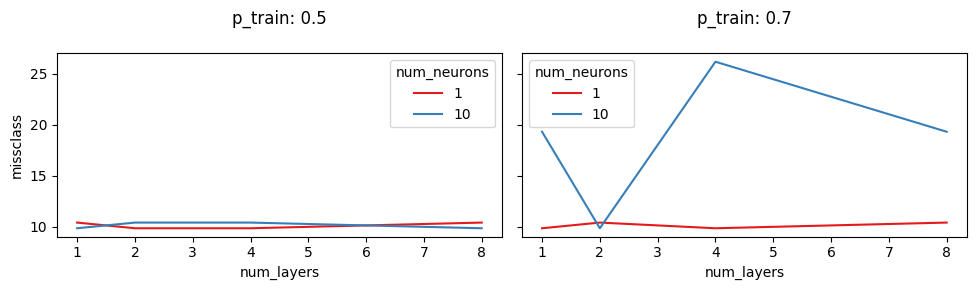

 -> duracion Plot /home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationrelu.png
: 0.46s
Plot /home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationtanh.png


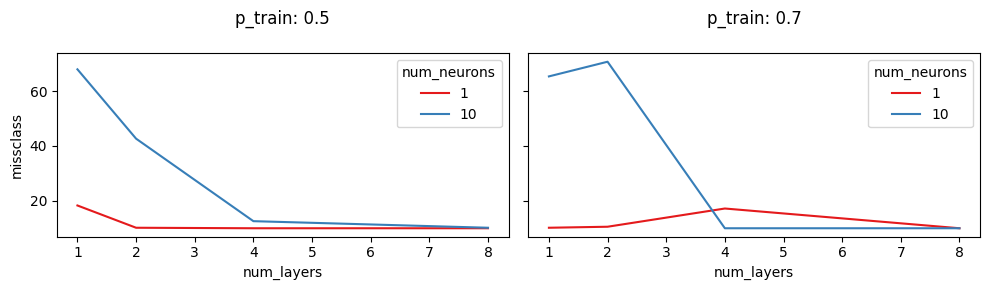

 -> duracion Plot /home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationtanh.png
: 0.33s


['/home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationrelu.png',
 '/home/crux/Repositories/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationtanh.png']

In [37]:
import seaborn as sns
from src.miscellaneous import NamedPartial

generic_plot(
    data_manager=dm, 
    x="num_layers", 
    y="missclass", 
    label="num_neurons", 
    missclass=lambda missclassification_error: np.mean(missclassification_error)*100, 
    plot_func=NamedPartial(sns.lineplot, palette="Set1"),
    axes_by=["p_train"],
    plot_by=["activation"],
    savefig=False,
    axes_xy_proportions=(5, 3)
)

### CO2 and Energy consumption information

In [32]:
print("The approximated CO2 produced during this experiments was: ", dm.CO2kg, "kg")
print("The approximated energy consumption during this experiments was: ", dm.electricity_consumption_kWh, "kWh")
print("The approximated computation time spent during this experiments was: ", dm.computation_time_s/60, "m")

The approximated CO2 produced during this experiments was:  2.7352977272947952e-05 kg
The approximated energy consumption during this experiments was:  0.000405049271034271 kWh
The approximated computation time spent during this experiments was:  33.83733567794164 m


For more detailed information about the consumption and time spent in each processing layer or plotting you can access directly to the DataFrame grouped by experiment or layer.

In [33]:
dm.get_emissions_summary(group_by_experiment=True, group_by_layer=True)

duration(s)  power_consumption(kWh)  \
experiment computation_layer                                        
MLLab      analysis              1.565820            2.535138e-08   
           figures             746.830325            3.510749e-04   
           preprocessing         1.372989            2.037603e-08   
           train              1280.471007            5.392860e-05   

                              CO2_emissions(kg)  
experiment computation_layer                     
MLLab      analysis                1.711979e-09  
           figures                 2.370809e-05  
           preprocessing           1.375994e-09  
           train                   3.641798e-06